# Minimax
In this notebook, we intend to use minimax to generate an AI that plays chess. To do this, we will first explore basic minimax then try to optimize our search using alpha-beta pruning and transposition tables. First, let's import a library called [python-chess](https://python-chess.readthedocs.io/en/latest/) which manages the chessboard for us:

In [4]:
import sys
!{sys.executable} -m pip install chess
import chess, chess.svg, chess.engine

## Introduction to Chess (Optional)

First of all, to make an AI that plays chess it helps to understand the basics of how to play the game. If you're not familiar with the rules here are the basics:

1. Each side starts with 1 King, 1 Queen, 2 Rooks, 2 Knights, 2 Bishops, and 8 Pawns in the starting configuration shown in the cell below.
2. Each piece moves in a specific way. You can find out how they move [here](https://en.wikipedia.org/wiki/Rules_of_chess#Basic_moves). 
3. The opponent's king is in **check** when it is being attacked by the one of your pieces. When this happens, the opponent must move such that the king is no longer in check. 
4. The goal of the game is to checkmate the opponent, which occurs when the opponent's king is in check but is unable to escape check.

These are just some important basic rules, you can find them in excruciating detail [here](https://en.wikipedia.org/wiki/Rules_of_chess).

Example 1: Starting configuration


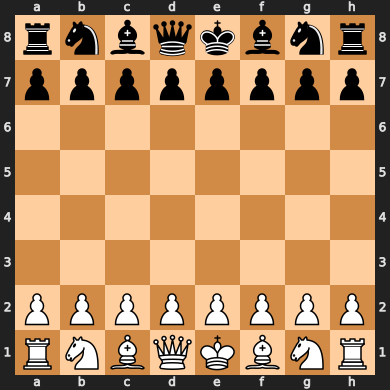

In [5]:
print("Example 1: Starting configuration")
board = chess.Board()
display(board)

Example 2: Black King is in check from the White Bishop and must escape or block


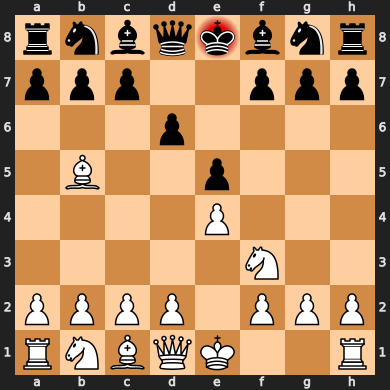

In [6]:
print("Example 2: Black King is in check from the White Bishop and must escape or block")
board = chess.Board('rnbqkbnr/ppp2ppp/3p4/1B2p3/4P3/5N2/PPPP1PPP/RNBQK2R b KQkq - 1 3')
display(board)

Example 3: Black King is in check but has nowhere to go, meaning this is Checkmate. The King is unable to capture the Queen because the Bishop is defending the Queen.


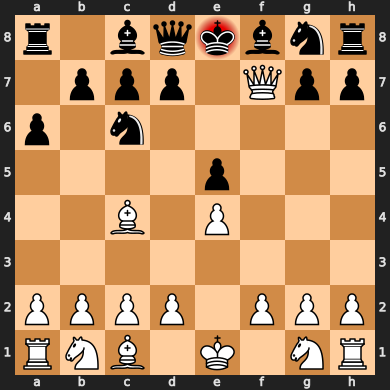

In [7]:
print("Example 3: Black King is in check but has nowhere to go, meaning this is Checkmate. The King is unable to capture the Queen because the Bishop is defending the Queen.")
board = chess.Board('r1bqkbnr/1ppp1Qpp/p1n5/4p3/2B1P3/8/PPPP1PPP/RNB1K1NR b KQkq - 0 4')
display(board)

## Learning Goals
- Explore ideas necessary to implement minimax: heuristic, depth
- Implement basic Minimax on chess
- Improve our algorithm with alpha-beta pruning
- Speed up further using a transposition table, and compare the implementations of the three functions
- Use iterative deepning to create a function which can search using a given amount of time

## 1. Basic Search Parameters
Minimax is an algorithm which searches for the optimal move in a given state, based on the assumption that the opponent will also make optimal moves in response. "If I do this, then the opponent will do this, then I'll do..."

However, since chess is such a complex game ($10^{120}$ possible games), we are unable to search the entire game tree. Hence, we must stop our search at a given **depth**, or number of moves from the original position that we search. For instance, if we only look at the next move, our depth is just 1. If we look at the next move and the opponent's responses, the depth would be 2.

Possible moves: [Move.from_uci('g1h3'), Move.from_uci('g1f3'), Move.from_uci('b1c3'), Move.from_uci('b1a3'), Move.from_uci('h2h3'), Move.from_uci('g2g3'), Move.from_uci('f2f3'), Move.from_uci('e2e3'), Move.from_uci('d2d3'), Move.from_uci('c2c3'), Move.from_uci('b2b3'), Move.from_uci('a2a3'), Move.from_uci('h2h4'), Move.from_uci('g2g4'), Move.from_uci('f2f4'), Move.from_uci('e2e4'), Move.from_uci('d2d4'), Move.from_uci('c2c4'), Move.from_uci('b2b4'), Move.from_uci('a2a4')]


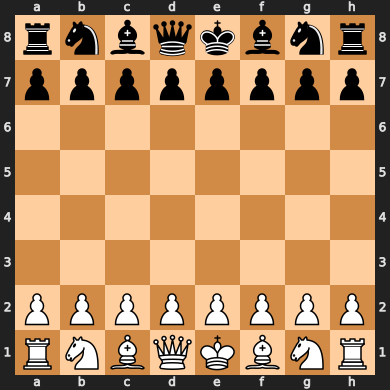

In [8]:
board = chess.Board()
print("Possible moves:", list(board.legal_moves))
display(board)

But what should we do once we reach that depth limit? We need a way to evaluate which positions are better than others, so we can choose the best outcome. We do this using a **heuristic**: a function which tries to approximate how "good" the position is for a given state.

For this notebook, we will use [Stockfish](https://stockfishchess.org/), an open source chess engine which can produce positional evaluations which we need. The engine is written in C, but luckily the python-chess library has a function which can handle engine files (which should be included with this notebook). If you can't find it, you can download it [here](https://stockfishchess.org/download/) under 64bit Linux.

In [34]:
import chess.engine
import os
# Create our engine
stockfish_directory = "./stockfish_20090216_x64"
os.chmod(stockfish_directory, 0o777)
engine = chess.engine.SimpleEngine.popen_uci(stockfish_directory)

def eval_board(board, time_limit = 0.001):
    """A function which evaluates the given position using Stockfish."""
    return engine.analyse(board, chess.engine.Limit(time=time_limit))['score'].white()

Stockfish gives each position a number which we call an evaluation. Since chess is a **zero-sum game**, meaning advantages for one player are the same as disadvantages for another, we can give each position just a single number: the higher it is, the better it is for the White side, the lower it is, the better it is for the Black side.

Here are some examples of positions we can evaluate:

Example 4: A relatively equal position with evaluation 0 given in centipawns (+100 = 1 pawn advantage for White).


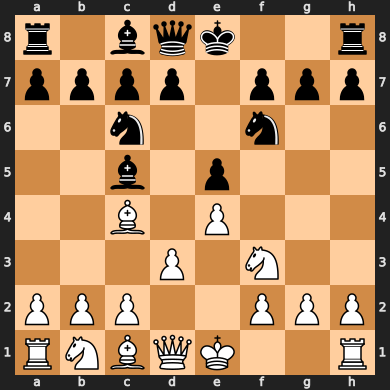

In [11]:
board = chess.Board("r1bqk2r/pppp1ppp/2n2n2/2b1p3/2B1P3/3P1N2/PPP2PPP/RNBQK2R w KQkq - 1 5")
print("Example 4: A relatively equal position with evaluation", eval_board(board), "given in centipawns (+100 = 1 pawn advantage for White).")
display(board)

Example 5: A position which is much better for Black (note White is missing a Knight for nothing), with evaluation -439 given in centipawns.


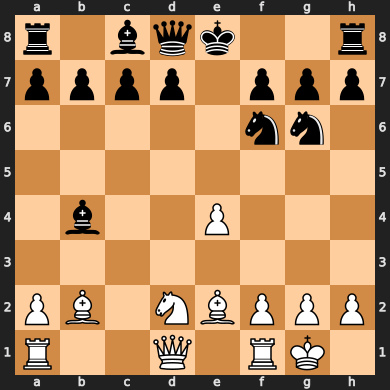

In [12]:
board = chess.Board("r1bqk2r/pppp1ppp/5nn1/8/1b2P3/8/PB1NBPPP/R2Q1RK1 w kq - 5 10")
print("Example 5: A position which is much better for Black (note White is missing a Knight for nothing), with evaluation", eval_board(board), "given in centipawns.")
display(board)

Example 6: White has checkmate in this position, and the engine gives evaluation #+2 given in Mate in X (2 moves until checkmate). Can you spot the checkmate?


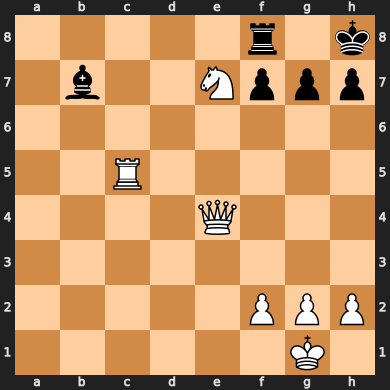

In [13]:
board = chess.Board("5r1k/1b2Nppp/8/2R5/4Q3/8/5PPP/6K1 w - - 0 1")
print("Example 6: White has checkmate in this position, and the engine gives evaluation", eval_board(board), "given in Mate in X (2 moves until checkmate). Can you spot the checkmate?")
display(board)

The fastest checkmate is given by 1. Qxh7+ Kxh7 2. Rh5#, given in [algebraic notation](https://en.wikipedia.org/wiki/Algebraic_notation_(chess)). This checkmate (where the Knight on e7 traps the King on the edge of the board) is called Anastasia's Mate.

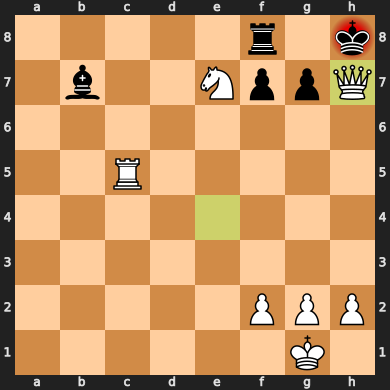

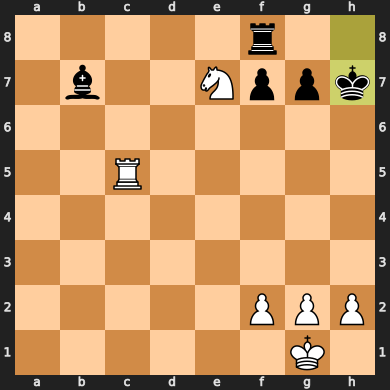

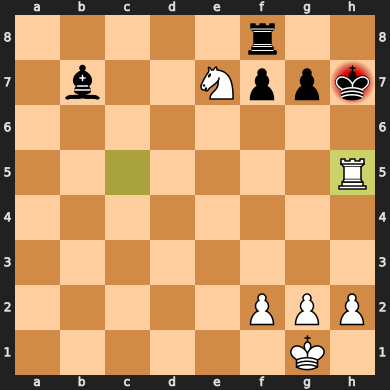

Evaluation: #+0


In [14]:
board.push_san("Qxh7+")
display(board)
board.push_san("Kxh7")
display(board)
board.push_san("Rh5#")
display(board)
print("Evaluation:", eval_board(board))

## 2. Basic Minimax Implementation
We will now implement the basic minimax algorithm with no pruning. If you've seen the note or slides, you would've seen that there we have a maximizing function and a minimizing function. However, we can do this slightly more cleverly, by using turn as one of our inputs (turn$=1$ for White to play, turn$=-1$ for Black to play). 

Remember that the idea underlying minimax is that we need to pick the best move **assuming that the opponent is able to select the best response.** See if you can fill in the function below to make the function work as intended.

In [15]:
def minimax(board, turn, depth, stop_time=None, get_move=True):
    """Finds and outputs the best move for the player based on turn. Outputs the move if get_move=True (typically on first call)
    and otherwise returns the evaluation of the position after searching DEPTH."""
    if depth == 0 or board.is_game_over(): # Stopping condition
        return eval_board(board) # Return a static evaluation when we can't search any more
    if stop_time and time.time() >= stop_time: 
        return None # If time runs out, stop searching
    
    best_value = -chess.engine.MateGiven if turn == 1 else chess.engine.MateGiven # current best score corresponding to best_move
    best_move = None # best_move so far
    current_value = 0 # The score for the current move

    for move in board.legal_moves: # Iterate over all legal moves
        board.push(move) # Make the move
        # Now we want to find the value of the position after making this move
        current_value = minimax(board, -turn, depth - 1, stop_time, False)
        # Undo the last made move
        board.pop()
        if current_value is None:
            return None # Time runs out
        # Update conditions
        if turn == 1:
            if current_value > best_value:
                best_value = current_value
                best_move = move
        else:
            if current_value < best_value:
                best_value = current_value
                best_move = move

    return best_move if get_move else best_value

Cool! Let's test our newly written function on a few basic cases. 

Example 7: We can take the Queen for free with Rxc7=c1c7. Will our engine find it?


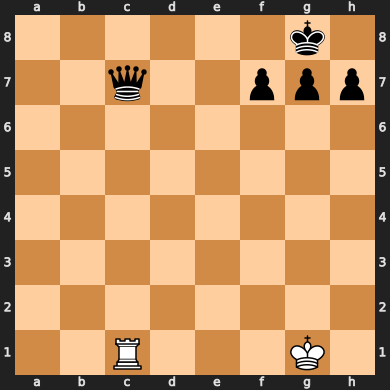

Move at depth 1: c1c7
Move at depth 2: c1c7
Move at depth 3: c1c7


In [16]:
board = chess.Board("6k1/2q2ppp/8/8/8/8/8/2R3K1 w - - 0 1")
print("Example 7: We can take the Queen for free with Rxc7=c1c7. Will our engine find it?")
display(board)
print("Move at depth 1:", minimax(board, 1, 1))
print("Move at depth 2:", minimax(board, 1, 2))
print("Move at depth 3:", minimax(board, 1, 3))

Example 8: An ordinary position, where many moves are acceptable. Let's see what our engine thinks the best move is at different depths.


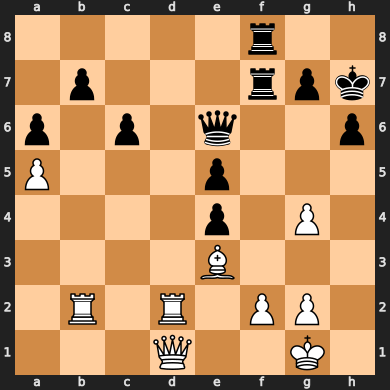

Depth 3 might take a while, so feel free to keep reading other cells as this runs.
Move at depth 1: g4g5
Move at depth 2: g4g5
Move at depth 3: g4g5


In [17]:
board = chess.Board("5r2/1p3rpk/p1p1q2p/P3p3/4p1P1/4B3/1R1R1PP1/3Q2K1 w - - 2 37")
print("Example 8: An ordinary position, where many moves are acceptable. Let's see what our engine thinks the best move is at different depths.")
display(board)
print("Depth 3 might take a while, so feel free to keep reading other cells as this runs.")
print("Move at depth 1:", minimax(board, 1, 1))
print("Move at depth 2:", minimax(board, 1, 2))
print("Move at depth 3:", minimax(board, 1, 3))

Interesting how we can get different moves at different depths! It's ok if you didn't since it's a little random. Every time we search a higher depth, we are guaranteed to get a move as good as or better than the previous depth. This is because each time we look at a potential set of moves, we look at the same set of moves but we look at each move in more detail.

However, the runtime leaves something to be desired... Even for "easy" positions where the correct move is extremely clear to a human (like example 8, where taking the Queen is obviously the best move), the minimax algorithm still searches for a long time. In the next section, we'll change that.

## 3. Alpha-Beta Pruning
Next, we will implement alpha-beta pruning, a technique which translates our intuition into reality. What intuition you might ask? The fundamental premise of alpha-beta pruning is if we've already found a move which we estimate is better than the current move, stop searching this move.

Be sure to remember that alpha is a lower bound on what we will search, and beta is an upper bound. Try implementing the function in the next cell:

In [18]:
def alpha_beta(board, turn, depth, stop_time=None, get_move=True, alpha=-chess.engine.MateGiven, beta=chess.engine.MateGiven):
    """Minimax using alpha-beta pruning. About the same inputs as minimax, but with alpha, beta as inputs as well."""
    if depth == 0 or board.is_game_over(): # Stopping condition
        return eval_board(board) # Return a static evaluation when we can't search any more
    if stop_time and time.time() >= stop_time: 
        return None # If time runs out, stop searching
    
    best_value = -chess.engine.MateGiven if turn == 1 else chess.engine.MateGiven # current best score corresponding to best_move
    best_move = None # best_move so far
    current_value = 0 # The score for the current move

    for move in board.legal_moves: # Iterate over all legal moves
        board.push(move) # Make the move
        # Now we want to find the value of the position after making this move
        current_value = alpha_beta(board, -turn, depth - 1, stop_time, False, alpha, beta)
        # Undo the last made move
        board.pop()
        if current_value is None:
            return None # Time runs out
        # Update conditions
        if turn == 1:
            if current_value > best_value:
                best_value = current_value
                best_move = move
            alpha = max(alpha, best_value)
        else:
            if current_value < best_value:
                best_value = current_value
                best_move = move
            beta = min(beta, best_value) 
        if beta <= alpha:
            break

    return best_move if get_move else best_value

Let's check out how well this works. Remember the previous position where we could take the Queen for free? Let's get an idea of how quickly alpha-beta pruning can solve this same problem:

Example 7 (cont.): We can take the Queen for free with Rxc7=c1c7. How quickly can alpha-beta pruning make this search?


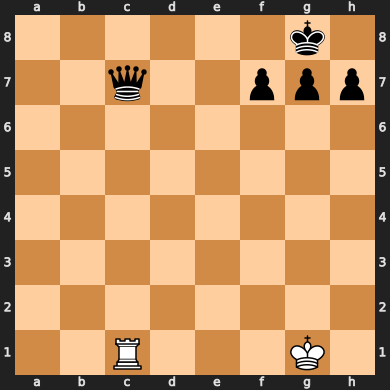

Move at depth 1: c1c7
Move at depth 2: c1c7
Move at depth 3: c1c7


In [19]:
board = chess.Board("6k1/2q2ppp/8/8/8/8/8/2R3K1 w - - 0 1")
print("Example 7 (cont.): We can take the Queen for free with Rxc7=c1c7. How quickly can alpha-beta pruning make this search?")
display(board)
print("Move at depth 1:", alpha_beta(board, 1, 1))
print("Move at depth 2:", alpha_beta(board, 1, 2))
print("Move at depth 3:", alpha_beta(board, 1, 3))

Let's try and compare the runtimes of minimax and alpha-beta pruning on different positions.

Example 7 (cont.): We can take the Queen for free with Rxc7=c1c7. Let's compare the runtimes of each algorithm.


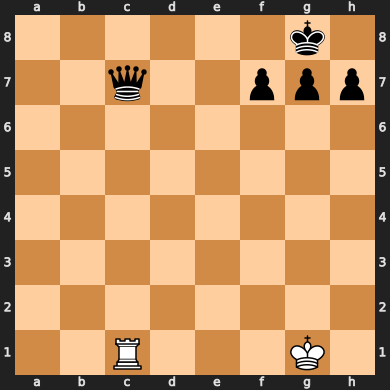

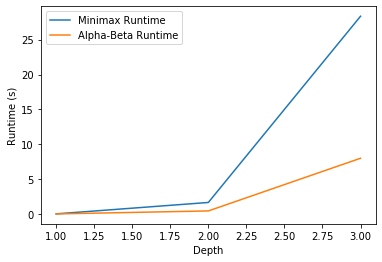

In [20]:
import matplotlib.pyplot as plt
import time
def plot_times(board, f1, f2, max_depth, f1_label, f2_label):
    f1_time, f2_time = [], []
    for i in range(max_depth):
        start = time.time()
        f1(board, 1, i + 1)
        f1_time.append(time.time() - start)
        start = time.time()
        f2(board, 1, i + 1)
        f2_time.append(time.time() - start)
    plt.plot(range(1, max_depth + 1), f1_time, label=f1_label)
    plt.plot(range(1, max_depth + 1), f2_time, label=f2_label)
    plt.xlabel("Depth")
    plt.ylabel("Runtime (s)")
    plt.legend()
    plt.show()
board = chess.Board("6k1/2q2ppp/8/8/8/8/8/2R3K1 w - - 0 1")
print("Example 7 (cont.): We can take the Queen for free with Rxc7=c1c7. Let's compare the runtimes of each algorithm.")
display(board)
plot_times(board, minimax, alpha_beta, 3, "Minimax Runtime", "Alpha-Beta Runtime")

Example 9: Just the starting position. Let's compare the runtimes of each algorithm.


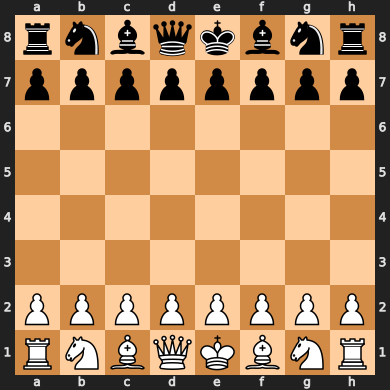

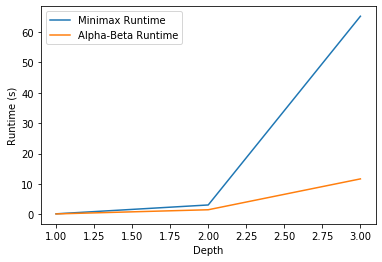

In [21]:
board = chess.Board()
print("Example 9: Just the starting position. Let's compare the runtimes of each algorithm.")
display(board)
plot_times(board, minimax, alpha_beta, 3, "Minimax Runtime", "Alpha-Beta Runtime")

Example 10: An endgame position which is easier to search more deeply. Notice how the alpha-beta runtime blows up much more slowly for higher depths.


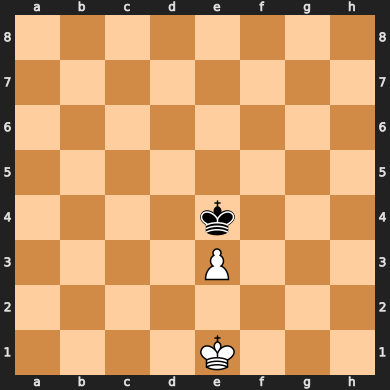

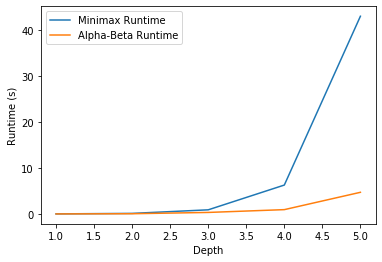

In [22]:
board = chess.Board("8/8/8/8/4k3/4P3/8/4K3 w - - 0 1")
print("Example 10: An endgame position which is easier to search more deeply. Notice how the alpha-beta runtime blows up much more slowly for higher depths.")
display(board)
plot_times(board, minimax, alpha_beta, 5, "Minimax Runtime", "Alpha-Beta Runtime")

## 4. Transposition Tables
Imagine from the starting position, the game goes as 1. e4 e5 2. Nf3 Nc6. Now imagine a game where the moves are reordered but lead to the same position: 1. Nf3 Nc6 2. e4 e5. Clearly, these two games ended up in the same position, and should give the same evaluation. In chess, we call this being the same **by transposition**.

Well, it would be redundant to search these two positions separately. That's why we will use a **transposition table** to store our previous search results so we don't have to search again.

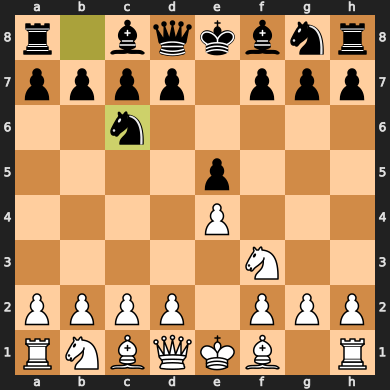

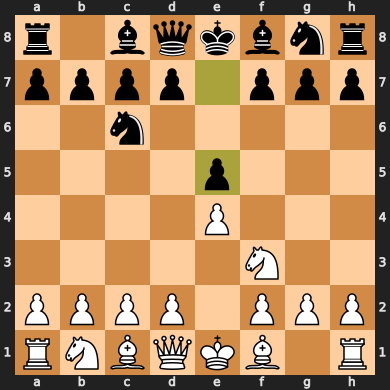

Are the boards the same? True


In [23]:
board1, board2 = chess.Board(), chess.Board()
# 1. e4 e5 2. Nf3 Nc6
board1.push_san("e4")
board1.push_san("e5")
board1.push_san("Nf3")
board1.push_san("Nc6")
# 1. Nf3 Nc6 2. e4 e5
board2.push_san("Nf3")
board2.push_san("Nc6")
board2.push_san("e4")
board2.push_san("e5")
display(board1)
display(board2)
print("Are the boards the same?", board1.board_fen() == board2.board_fen())

We can't really save EVERY position we see though, since that would take way too much memory over time. So instead, we keep a fixed table size where we store each position and score. Also, we need to be able to quickly retrieve scores from the table, so we will use a **hash function**: a function that maps positions to integers consistently. The hash function is called the [Zobrist hasher](https://en.wikipedia.org/wiki/Zobrist_hashing), and there is an implementation of the function in the chess libaray (gosh, is there anything it doesn't have?). 

So our hash function will map positions to integers, and we will overwrite the previous entry in the table. There might be overlaps due to the size of our table, but that's alright. When we run our AI, we expect to see similar positions in the future to those that we see now. 

In [24]:
from chess.polyglot import POLYGLOT_RANDOM_ARRAY, ZobristHasher
TABLE_SIZE = 5000 # Fix our table size
t_table = [None] * TABLE_SIZE # Make our transposition table
hasher = ZobristHasher(POLYGLOT_RANDOM_ARRAY) # This function makes our hasher

Note that the convention that we have chosen for our transposition table will be such that each position is stored as (position, depth, value, move, turn):
- Position: The current position given in [FEN](https://en.wikipedia.org/wiki/Forsyth%E2%80%93Edwards_Notation).
- Depth: The depth we searched this position. Note we don't want to use this table element if the depth we searched was less than what we want now.
- Value: The score which we deemed the position to be (note this can be inaccurate due to pruning!).
- Move: The best move in response (note this can be inaccurate due to pruning!).
- Turn: The player whose turn it is.

In [25]:
def alpha_beta_table(board, turn, depth, stop_time=None, get_move=True, alpha=-chess.engine.MateGiven, beta=chess.engine.MateGiven):
    """Alpha-beta pruning which uses a transposition table to speed up when we see positions we have already searched."""
    if depth == 0 or board.is_game_over(): # Stopping condition
        return eval_board(board) # Return a static evaluation when we can't search any more
    if stop_time and time.time() >= stop_time: 
        return None # If time runs out, stop searching
    
    board_index = hasher(board) % TABLE_SIZE # Calculate the index of our hash table for this position
    table_entry = t_table[board_index]
    # We want the position in the table to be the same as the current one
    if table_entry and table_entry[0] == board.board_fen() and table_entry[4] == turn:
        # We want a depth as high as before
        if table_entry[1] >= depth:
            if get_move:
                return table_entry[3]
            else:
                return table_entry[2]
    
    best_value = -chess.engine.MateGiven if turn == 1 else chess.engine.MateGiven # current best score corresponding to best_move
    best_move = None # best_move so far
    current_value = 0 # The score for the current move

    for move in board.legal_moves:
        board.push(move)
        current_value = alpha_beta_table(board, -turn, depth - 1, stop_time, False, alpha, beta)
        board.pop()
        if current_value is None:
            return None
        if turn == 1:
            if current_value > best_value:
                best_value = current_value
                best_move = move
            alpha = max(alpha, best_value)
        else:
            if current_value < best_value:
                best_value = current_value
                best_move = move
            beta = min(beta, best_value) 
        if beta <= alpha:
            break
    
    # Save the current position along with the relevant details
    t_table[board_index] = (board.board_fen(), depth, best_value, best_move, turn)

    return best_move if get_move else best_value

Let's try running the function on the same position as before. The runtimes might be comparable, but try running the cell again and you should see the runtime of the table just be nearly a flat 0.

Example 10 (cont.): An endgame position which is easier to search more deeply. If you run this cell twice, you should see the runtime of the tablebase algorithm as 0.


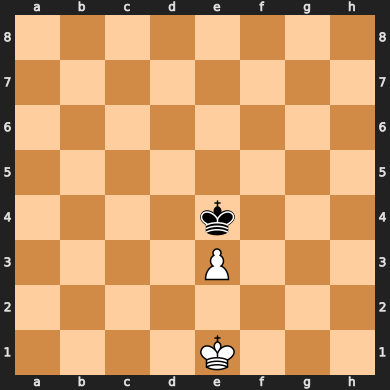

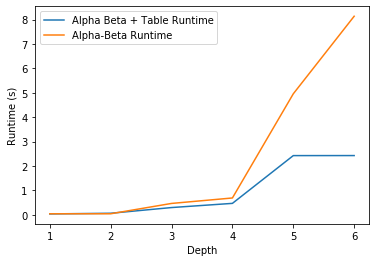

In [26]:
board = chess.Board("8/8/8/8/4k3/4P3/8/4K3 w - - 0 1")
print("Example 10 (cont.): An endgame position which is easier to search more deeply. If you run this cell twice, you should see the runtime of the tablebase algorithm as 0.")
display(board)
plot_times(board, alpha_beta_table, alpha_beta, 6, "Alpha Beta + Table Runtime", "Alpha-Beta Runtime")

Example 11: An average position. If you run this cell twice, you should see the runtime of the tablebase algorithm as 0.


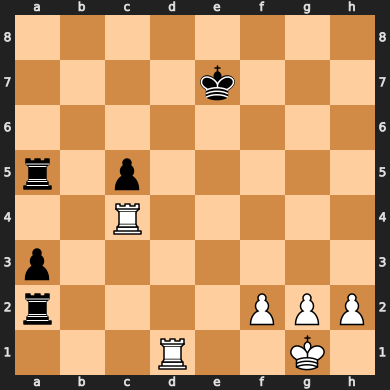

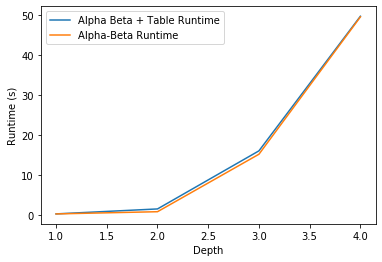

In [27]:
board = chess.Board("8/4k3/8/r1p5/2R5/p7/r4PPP/3R2K1 w - - 3 41")
print("Example 11: An average position. If you run this cell twice, you should see the runtime of the tablebase algorithm as 0.")
display(board)
plot_times(board, alpha_beta_table, alpha_beta, 4, "Alpha Beta + Table Runtime", "Alpha-Beta Runtime")

It's interesting to see how much the runtimes of the algorithms in the two examples differ. In the first position, since there are fewer pieces and we search at a higher depth, we observe that the tablebase makes the search much faster: much of the time, regardless of where we move we may end up in the same position. However, for the second position the runtimes are nearly the same, since we see very few transpositions since we search a lower depth and each move leads to a very different result.

## 5. Iterative Deepening
Chess tournaments have many formats, but they usually have a time limit for each player. At the moment our AI runs at a fixed depth. However, we have no idea how long this depth takes to run. Clearly, using depth is not a very realistic way to manage time.

Because of that, we can use **iterative deepening** instead, which is a technique which involves increasing search depth until time runs out. So that would mean we search depth 1, depth 2, depth 3, ... until we no longer have any time left, and use the move found from the highest depth. Try implementing it in the cell below:

In [29]:
def iterative_deepening(board, time_limit):
    """Run iterative deepening, stopping on the last depth once time runs out"""
    stop_time = time.time() + time_limit # Calculate stop time
    current_depth = 1 # The depth we are currently searching at
    move = list(board.legal_moves)[0] # Default move. This is our best found move so far
    while time.time() < stop_time:
        recent_move = alpha_beta_table(board, 1 if board.turn else -1, current_depth, stop_time=stop_time)
        if recent_move: # If we run out of time, alpha_beta_table returns None
            move = recent_move
        current_depth += 1
    return move

Hooray! And now our AI is all done. Let's see the AI play itself. You can set the time limit per move in seconds by changing the time_per_move variable.

In [ ]:
import IPython.display
board = chess.Board()
time_per_move = 5
while not board.is_game_over():
    last_move = iterative_deepening(board, time_per_move)
    board.push(last_move)
    board_view = chess.svg.board(board, lastmove = last_move, size=350)
    IPython.display.clear_output()
    display(board_view)
import chess.pgn
print(chess.pgn.Game().from_board(board))

If you're feeling brave, you can give it a try and play the AI yourself.

In [ ]:
board = chess.Board()
time_per_move = 5
player_side = input("Would you like to play as White or Black? (1 for White, -1 for Black): ")
if player_side == "1":
    board_view = chess.svg.board(board, size=350)
    IPython.display.clear_output()
    display(board_view)
    while True:
        move = input("Enter your move in algebraic notation: ")
        try:
            last_move = board.parse_san(move)
            board.push(last_move)
            break
        except ValueError as e:
            print("Invalid move.")
            pass
    board_view = chess.svg.board(board, lastmove = last_move, size=350)
    IPython.display.clear_output()
    display(board_view)
while not board.is_game_over():
    last_move = iterative_deepening(board, time_per_move)
    board.push(last_move)
    board_view = chess.svg.board(board, lastmove = last_move, size=350)
    IPython.display.clear_output()
    display(board_view)
    if board.is_game_over():
        break
    while True:
        move = input("Enter your move in algebraic notation: ")
        try:
            last_move = board.parse_san(move)
            board.push(last_move)
            break
        except ValueError as e:
            print("Invalid. Try again.")
            pass
    board_view = chess.svg.board(board, lastmove = last_move, size=350)
    IPython.display.clear_output()
    display(board_view)
print(chess.pgn.Game().from_board(board))

And that's all! I hope you enjoyed! While today we may have made an AI specifically for chess, all of these ideas can be applied to any turn-based game you desire, with some minor modifications.